# Data Cleaning and Feature Engineering

* Focus on businesses in the shopping industry which still operate and located in the United States - reduced the number of businesses from 210k to 20k.
* Accordingly, select only the reviews belong to a shopping business - reduced the number of reviews from 8.2m to 485k
* Sample size for the users reduced from ~2m to 277k

# Import Libraries & Read Data

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))

In [2]:
# import sys
# !{sys.executable} -m pip install textblob
# !{sys.executable} -m pip install googletrans
# !{sys.executable} -m pip install langdetect
# !{sys.executable} -m pip install contractions
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download en

In [3]:
import pandas as pd
import numpy as np
import scipy.stats
import nltk
from nltk.classify import TextCat
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer
from string import whitespace, punctuation, digits
from langdetect import detect, lang_detect_exception
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import re
import contractions
import spacy
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
# nltk.download('crubadan')
snowball_stemmer = SnowballStemmer('english')
stop_words = stopwords.words('english')
nlp = spacy.load('en', disable=['parser', 'ner'])

In [4]:
df = pd.read_csv('yelp_review_data.csv')
df.head()

,review_id,user_id,business_id,review_stars,review_useful,review_funny,review_cool,review,review_date
0,YkpjR5N5TLkwHi20IZ15zg,xDtS2iKsJuVUVzB2YhfPsg,f9NumwFMBDn751xgFiRbNA,4.0,23,2,4,Driving more than an half-hour to get to a gun...,2012-06-26 00:48:30
1,rB1D3_F5cED234lqvnJK1A,46HhzhpBfTdTSB5ceTx_Og,f9NumwFMBDn751xgFiRbNA,4.0,15,0,3,"My dad came down to the area to visit, and whi...",2012-05-29 23:44:04
2,S5UuPziiDiEqFPuX5bY-kg,vBxT4_bjFrbZEarWz6vsCQ,f9NumwFMBDn751xgFiRbNA,4.0,0,0,0,First time and and last time. I'm a punk!!! 2...,2017-06-18 00:24:54
3,nwEXkyNGhtsRCAv7kS9Urg,qiz4Ri_cMSsoH3ccN19eAw,f9NumwFMBDn751xgFiRbNA,5.0,2,0,0,"Besides being a great range, they are not chea...",2016-02-14 02:28:57
4,oT2weUEWpPOqIAer3MmrCg,0awwOxKGZVDt52vxkEX-eA,f9NumwFMBDn751xgFiRbNA,1.0,2,1,0,"Place is nice to look at, but wouldn't really ...",2014-05-28 20:00:46


In [5]:
# check if there is duplicated reviews
print('There are {} duplicated reviews.'.format(
    df[df.review.duplicated()].shape[0]))

There are 1244 duplicated reviews.


In [6]:
# drop duplicated reviews
df.drop_duplicates(subset='review', keep='first', inplace=True)

# Basic Feature Engineering

In [7]:
df['word_tokens'] = df.review.apply(nltk.word_tokenize)

In [8]:
# Feature engineering
df['length_sent'] = df.review.apply(lambda x: len(nltk.sent_tokenize(x)))
df['length_word'] = df.word_tokens.apply(lambda x: len(x))
df['set_word'] = df.word_tokens.apply(lambda x: len(set([w.lower() for w in x])))
df['length_punct'] = df.review.apply(lambda x: len([p for p in x if p in punctuation]))
df['length_stopwords'] = df.word_tokens.apply(lambda x: len([w for w in x if w.lower() in stop_words]))
df['length_upper'] = df.word_tokens.apply(lambda x: len([w for w in x if w.isupper()]))
df['length_title'] = df.word_tokens.apply(lambda x: len([w for w in x if w.istitle()]))
df['length_char'] = df.review.apply(lambda x: len([char for char in x if char not in punctuation + whitespace]))
df['average_length_words'] = df.word_tokens.apply(lambda x: np.mean([len(w) for w in x]))

## Exploratory Data Analysis

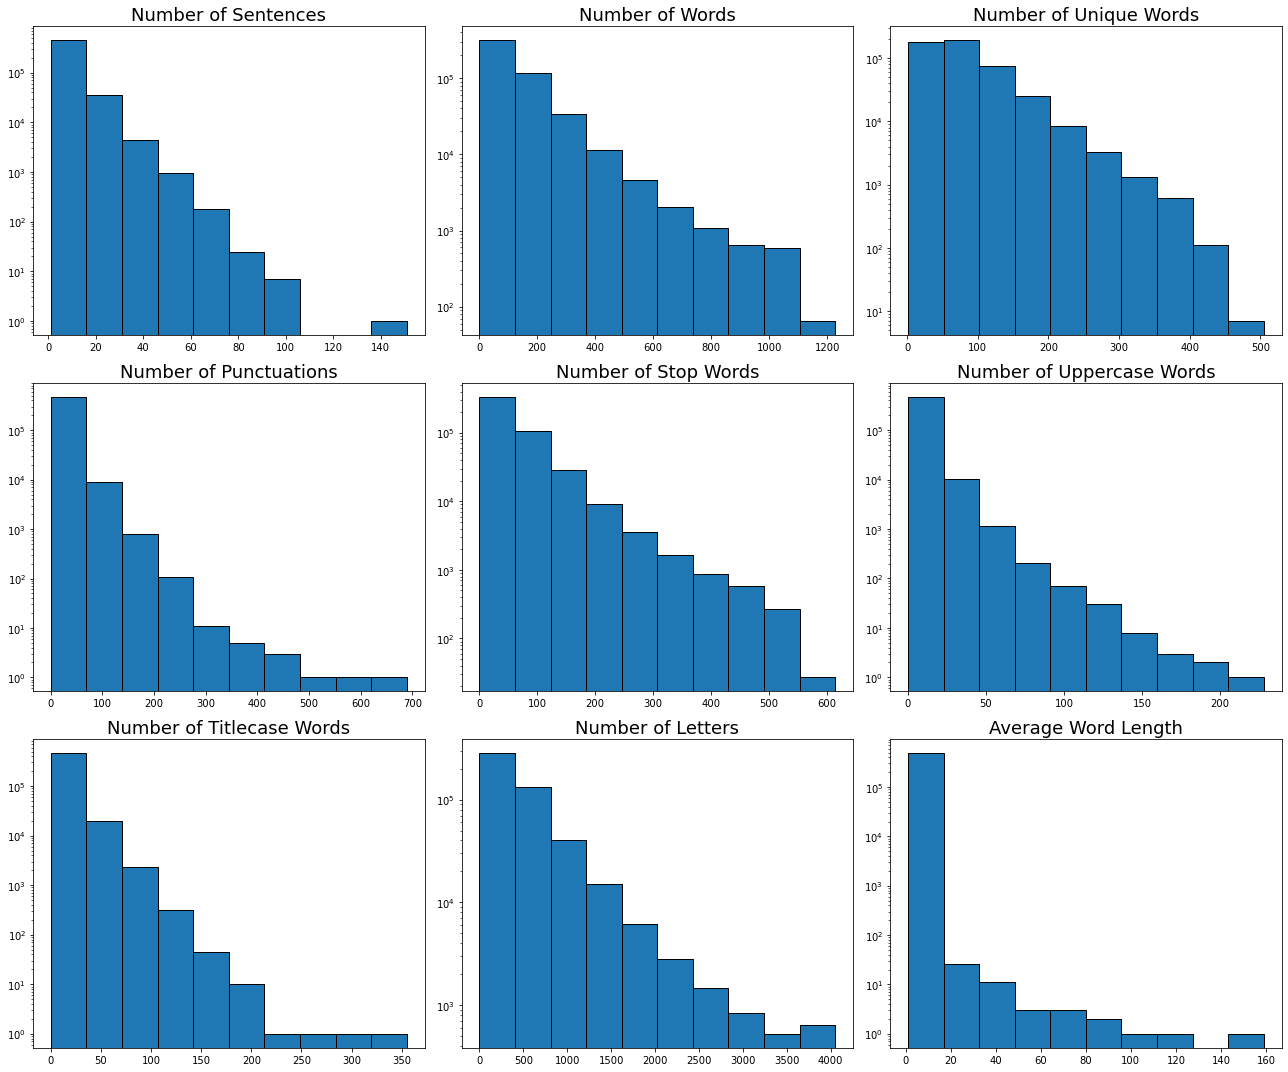

In [9]:
features = ['length_sent', 'length_word', 'set_word', 'length_punct',
            'length_stopwords', 'length_upper', 'length_title', 'length_char',
            'average_length_words']
titles = ['Number of Sentences', 'Number of Words', 'Number of Unique Words',
          'Number of Punctuations', 'Number of Stop Words',
          'Number of Uppercase Words', 'Number of Titlecase Words',
          'Number of Letters', 'Average Word Length']
d = dict(list(zip(features, titles)))
# compare distributions of features by class in order to find the
# features that can identify fraudulent transactions
fig, axes = plt.subplots(3, 3)  # generates figure and axis objects
fig.set_size_inches([18, 15])  # adjust the figure size in inches
axes = axes.flatten()
for feature, ax in zip(list(d.keys()), axes):
    # plot the distribution of not helpful
    ax.hist(df[feature].values, edgecolor='k')
    ax.set_yscale('log')
    ax.set_title(d[feature], size=18)
plt.tight_layout()
plt.show()

* The histograms are log-scaled in order to see extreme values.
* __Average Word Length__ and __Number of Punctuations__ have suspicious values.

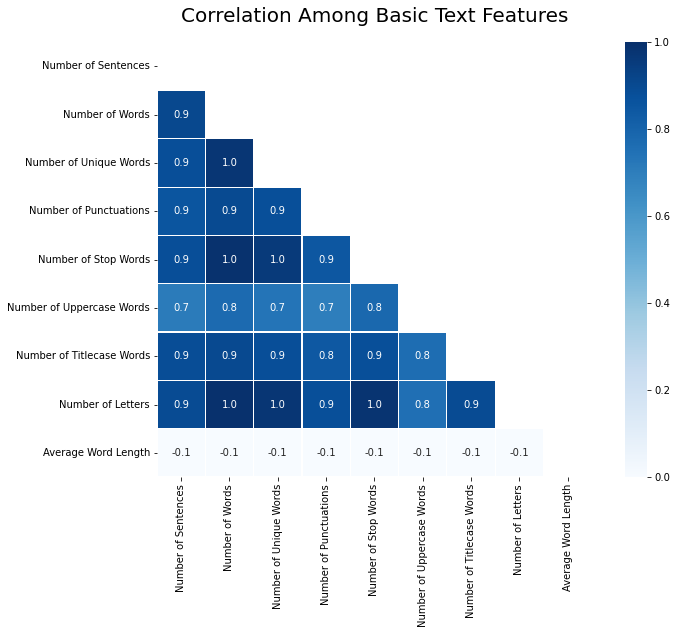

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
data = df.loc[:, [
    'length_sent', 'length_word', 'set_word', 'length_punct',
    'length_stopwords', 'length_upper', 'length_title', 'length_char',
    'average_length_words'
]]
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True  # shows only the left lower triangle

fig, axes = plt.subplots()  # generates ax and figure object
fig.set_size_inches([12, 8])  # set the figure sizes in inches
# plots the heatmap
ax = sns.heatmap(corr,
                 mask=mask,
                 vmin=0,
                 vmax=1,
                 linewidth=0.2,
                 square=True,
                 cmap='Blues',
                 annot=True,
                 fmt='.1f')
ax.set_yticklabels(titles, rotation=0, fontsize="10", va="center")
ax.set_xticklabels(titles)
# set title for the figure
ax.set_title('Correlation Among Basic Text Features', size=20, pad=20)
# shows the plot
plt.show()

In [11]:
pd.DataFrame(
    {
        'Helpful Votes': [
            scipy.stats.pearsonr(data[feature].values,
                                 df.review_useful.values)[0]
            for feature in data.columns
        ]
    },
    index=[
        'Number of Sentences', 'Number of Words', 'Number of Unique Words',
        'Number of Punctuations', 'Number of Stop Words',
        'Number of Uppercase Words', 'Number of Titlecase Words',
        'Number of Letters', 'Average Word Length'
    ])

,Helpful Votes
Number of Sentences,NaN
Number of Words,0.226591
Number of Unique Words,0.238684
Number of Punctuations,0.228610
Number of Stop Words,0.212663
Number of Uppercase Words,0.155164
Number of Titlecase Words,0.231067
Number of Letters,0.227132
Average Word Length,-0.019772


In [12]:
for feature in data.columns:
    print('The Pearson correlation coeffiecient between helpful votes and {}: {}'
          .format(feature, scipy.stats.pearsonr(data[feature].values,
                                                df.review_useful.values)))

The Pearson correlation coeffiecient between helpful votes and length_sent: (0.2208958834475414, 0.0)
The Pearson correlation coeffiecient between helpful votes and length_word: (0.2265907353206599, 0.0)
The Pearson correlation coeffiecient between helpful votes and set_word: (0.23868401841083947, 0.0)
The Pearson correlation coeffiecient between helpful votes and length_punct: (0.22861040802078528, 0.0)
The Pearson correlation coeffiecient between helpful votes and length_stopwords: (0.2126627083486337, 0.0)
The Pearson correlation coeffiecient between helpful votes and length_upper: (0.15516393476351992, 0.0)
The Pearson correlation coeffiecient between helpful votes and length_title: (0.23106721988602336, 0.0)
The Pearson correlation coeffiecient between helpful votes and length_char: (0.2271323207166383, 0.0)
The Pearson correlation coeffiecient between helpful votes and average_length_words: (-0.019772267848911243, 4.304175628876829e-43)


__Number of Sentences__

In [13]:
print(df[df.length_sent > 100].review.values[0]) # each dot counted as a separate sentence

Maybe it is just me.  Maybe I am just too stupid to make the connection.  Maybe I don't pay attention until I care.  Maybe I am self absorbed . . . 
or maybe it is I know the Cidade Maravilhosa . . . . Rio de Janiero . . . 

I had no idea that the Rio is a Rio de Janeiro themed hotel . . . Ipanema Tower . . .  Buzios Seafood Restaurant . . . come on I should have connected the dots immediately . . . Ipanema is an upscale neighborhood and beach . . . Buzios an upscale resort town north of Rio . . . I have figured it out immediately but I did not . . . somehow even with all the clues it just lacked the clues I need for it to be Rio.  But back to that later . . . 

I got a great rate so off to Rio I go.  The hotel is your typical casino resort . . . except all the rooms are suites.  Great, I like some space and space is what I got and it was delivered in a clean, efficient manner.  Nothing to complain about especially for the price, $43/night.  The food left something to be desired . . . 

In [14]:
df[df.length_sent > 100].review.values[0].count('.')

150

__Number of Words__

In [15]:
print(df[df.length_word > 1200].review.values[0]) # check if anything wrong with the review

INCREDIBLY DISHONEST. My family has already spent $680 dollars with Jenny...and she kept lying to me yesterday at my dress fitting. Here's what happened:

My sister used Jenny for alterations on her wedding dress. She paid $500 (knowing that while expensive, Jenny does good work). And my sister recommended her to me for my upcoming wedding. 

Before I had Jenny fit my dress, my fiancé and I brought her his tuxedo. She charged us $160 for the jacket only. We paid it and tipped her $25 as a gesture, knowing she would be doing my dress next (what a mistake). I also left my dress with her and booked my first fitting for a month out. 

When I went in yesterday for my first fitting, I brought my stepmom with me. Jenny handed me the someone else's dress (someone named Emmy) and told me to put it on. I let her know she had the wrong dress and then once I was in my dress, this is what I asked for:

1. Straps removed
2. Dress taken in at bust
3. Breast area made less "pointy"
4. 1-point bustle
5

__Number of Unique Values__

In [16]:
t = df[df.set_word > 500].word_tokens.values
print('   '.join(set([w.lower() for w in t[0]])))

some   pink   owwch   eckrich   oddities   ''   from   back   innumerable   head-scratching   not   spectrum   unblinking   pushing   wanted   here   examine   bed   certain   light   school   an   again   stabbing   grabbed   flooring   other   reducing   i   starboard   headed   all   free   ~~~~   60w   sitting   there   turn   items   must   longer   -i   nearing   dahdah-dah-dah-dah-dah-dahdah   .....   hear   just   despite   purpose   quite   pulling   din   fever   storage   rode   stripping   satisfaction   interest   in   language   side   yikes   -except   of   being   madly   .   fling   was   hidden   cautious   terrifying   might   death   foreign   unmistakably   as   one   characters   nice   ca   else   hanging   full   ready   infected   know   100   speed   looked   vaccine   action   times   up   seemed   toe   up-aisles   momentarily   torn   horror   filled   hours   twisted   came   shiny   mirror   delayed   yet   hand   route   red   stop   cap   only   black  

__Number of Title Case Words__

In [17]:
t = df[df.length_title > 200].review.values
for review in t:
    print(review)
    print('='*80)

I Would Give David 10 Stars If I Could. Long Story Short. I Was At Loews Looking For Replacement Parts For A Shower Handle That Snapped Off And Took The Cartridge Stem With It. I Had To Shut Off The Water Supply To The House, While Looking For The Parts To Fix It. I Noticed A Gentleman Looking At The Same Parts That I was Looking At. I Could Not Find The Part I Needed Because Loews Did Not Have The Parts In Stock. So I Asked The Gentleman Standing Next To Me If He Knew Anything About Pluming Or Any Other Places I Could Get The Parts I Needed.  He Replied Yes. And He Told Me He Had The Parts In His Truck. "NO CHARGE" I Offered Him Money For The Parts, And He Refused it. He Just Gave Me His Card And Drove Away  I Hurried Home to Fix The Shower, But Due To A Previous Plumbers Botched Job It Was Extremely Difficult To Fix. I Called David Around 3:00pm And Told Him That It Was Too Difficult to Repair. He Called Me Back With In 30mins And Told Me He Would Come Over And Fix The Problem. He Sh

__Number of Letters__

In [18]:
t = df[df.length_char > 4000].review.values
for review in t:
    print(review)
    print('='*80)

Taliesin West emerges naturally from the desert floor -you can't see it on approach because it's built with a low profile and designed to blend in with its desert surroundings. The complex just outside Scottsdale, AZ., was architect Frank Lloyd Wright's winter home, workplace, and school in the desert from 1937 until his death in 1959 at the age of 91. 

Drawing its name from Frank Lloyd Wright's summer home (Taliesin, in Spring Green, WI),  it's the main campus of the School of Architecture and houses the Frank Lloyd Wright Foundation. Many of Wright's most famous buildings were designed in the drafting room here (including the Guggenheim Museum in NYC). Open to the public for tours, Taliesin West is located on Frank Lloyd Wright Boulevard in Scottsdale, Arizona (a suburb of Metropolitan Phoenix). 

The place is amazing, with stunning desert views of Scottsdale and Phoenix beyond (though marred by the power lines FLW wrote President Truman about, demanding they be removed and rerouted

In [19]:
df[df.average_length_words > 20].loc[:, ['review', 'average_length_words']].head()

,review,average_length_words
23351,今回はSamsung Gear S2 4G版をプリペイド契約で可能かを聞きに行ってきましたが...,30.25
25253,很棒的一家連鎖超市.商品的品質口味適合嗎？好壞？未開封都不知道.只要您有一點意願購買.他們立...,51.00
40372,20年程前にロサンゼルス在住の友達に教えてもらい、その後どの都市に行っても探して買い物に行っ...,41.25
51533,這是一家連鎖超市.商品很多.包括生鮮食品.蔬果.肉類.冷凍食品.冰品.雜糧.麵包.藥物.清潔...,26.00
60029,ここのGoodwillは他と比べると綺麗な感じがする。\n陳列棚も整理されてて見やすかったで...,20.25


* Reviews with higher average length word is tend to belong to another language
* Let's detect the language of each review and keep only English

In [20]:
def get_language(text):
    try:
        return detect(text)
    except:
        return 'error'

In [21]:
df['language'] = df.review.apply(get_language)

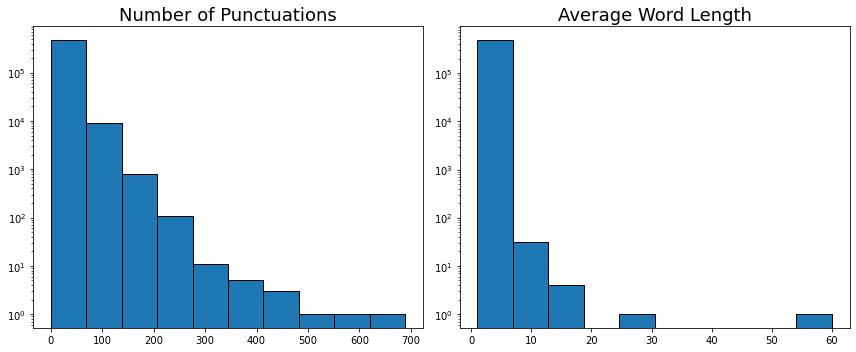

In [22]:
df = df[df.language == 'en']
features = ['length_punct', 'average_length_words']
titles = ['Number of Punctuations', 'Average Word Length']
d = dict(zip(features, titles))
# compare distributions of features by class in order to find the
# features that can identify fraudulent transactions
fig, axes = plt.subplots(1, 2) # generates figure and axis objects
fig.set_size_inches([12, 5]) # adjust the figure size in inches
axes = axes.flatten()
for feature, ax in zip(d.keys(), axes):
    # plot the distribution of not helpful
    ax.hist(df[feature].values, edgecolor='k')
    ax.set_yscale('log')
    ax.set_title(d[feature], size=18)
plt.tight_layout()
plt.show()

In [23]:
df.reset_index(drop=True, inplace=True)
temp = df[df.average_length_words > 6].loc[:, [
    'review_id', 'review', 'average_length_words', 'language', 'review_useful']]
display(temp.head())
for idx, review in zip(temp.index, temp.review.values):
    print(idx)
    print(review)
    print('-' * 80, end='\n\n')

,review_id,review,average_length_words,language,review_useful
15099,u6oRV98Oqhe2X7mR6KIeJQ,CCW course instructors are extremely professio...,6.303030,en,0
22612,cF1jYxvgHXoIN0AO5P78pQ,Warning avoid this location completely.... hor...,6.625000,en,8
28307,64KnvdzFZzSBGT0Hn9CvZw,Be very careful of this establishment. They j...,7.418605,en,1
37668,gWoNdTCX7jcN0wvMF9nvkA,Excellent lounge extremely friendly staff and ...,7.272727,en,2
38900,E8D14Bh0mw1j10O4xGp1yQ,https://patch.com/pennsylvania/pittsburgh/pitt...,14.625000,en,0


15099
CCW course instructors are extremely professional, knowledgable and friendly. Geza and Darius delivered an engaging and informative presentation of incredible value.
Their commitment is unparalleled and appreciated.Highly recommended!!
--------------------------------------------------------------------------------

22612
Warning avoid this location completely.... horrible service
--------------------------------------------------------------------------------

28307
Be very careful of this establishment.  They just received an 82 sanitary rating.  Beware!
Here is their rating on their latest inspecition:

https://www.bizjournals.com/charlotte/news/2017/09/08/which-mecklenburg-county-restaurants-didnt-make.html?ana=e_me_set1&s=scroll&ed=2017-09-08&u=bB8v3OOWQQrLT0a13p%2FK2w06587473&t=1504876484&j=78797771
--------------------------------------------------------------------------------

37668
Excellent lounge extremely friendly staff and owners friendly customers
Highly recommende

* As seen above, `http` and `https` links change the average length of word feature, dramatically.
* It is required to discard all links during text normalization.
* Manual check after language detection may be required.
* URLs and consecutive punctuations inflated __Average Length of Words__ and __Number of Punctuation__

In [24]:
# manually correction of reviews
missing_text = 'Great place to handle all your families eye care needs. Staff is friendly and knowledgeable. They have always done a great job with my daughter.'
df.loc[df.review.apply(lambda x: x.startswith('Greatplacetohandleallyourfa')), 'review'] = missing_text
# drop non-english review
df.drop(135564, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
# save to a csv file
df.to_csv('text_basic_features.csv', index=False)

# Data Cleaning

In [25]:
# remove urls from reviews
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [26]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [27]:
# remove urls
data = df.loc[:, ['review_id', 'review', 'review_stars', 'review_useful']]
data['review_clean'] = data.review.apply(remove_url)
# remove emoji
data.review_clean = data.review_clean.apply(remove_emoji)
# separate hyphen words
data.review_clean = data.review_clean.apply(lambda x: x.replace('-', ' '))
# replace $ as a text
data.review_clean = data.review_clean.apply(
    lambda x: x.replace('$ ', 'dollar').replace('$', 'dollar '))
# fix contractions such as I'm -> I am
data.review_clean = data.review_clean.apply(contractions.fix)
# remove hashtags and mentions
data.review_clean = data.review_clean.apply(lambda x: re.sub(r"(?:\@|#)\S+", "", x))
# replace punctuations with whitespace
data.review_clean = data.review_clean.apply(
    lambda x: re.sub(r"""[!"#$%&\'()*+,-./:;<=>?@\[\]^_`{|}~€£¥]""", " ", x))
# remove digits
data.review_clean = data.review_clean.apply(
    lambda x: ''.join([char for char in x if char not in digits]))
# remove stopwords
data.review_clean = data.review_clean.apply(
    lambda x: ' '.join([w.lower() for w in nltk.word_tokenize(x)
                        if w.lower() not in stop_words]))
# lemmatizer
data.review_clean = data.review_clean.apply(lambda x: nlp(x))
# stemmer
data.review_clean = data.review_clean.apply(
    lambda x: ' '.join([snowball_stemmer.stem(w) for w in [token.orth_ for token in x]]))
# drop if review is empty string
data = data.loc[data.review_clean != '']

In [28]:
# Feature engineering
data['length_word'] = data.review_clean.apply(lambda x: len(x.split()))
data['set_word'] = data.review_clean.apply(lambda x: len(set(x.split())))
data['length_char'] = data.review_clean.apply(lambda x: len([char for char in x if char not in whitespace]))
data['average_length_words'] = data.review_clean.apply(lambda x: np.mean([len(w) for w in x.split()]))

In [29]:
temp = df.loc[:, ['review_id', 'length_sent', 'length_punct', 'length_stopwords', 'length_upper', 'length_title']]
data = data.merge(temp, on='review_id', validate='one_to_one')

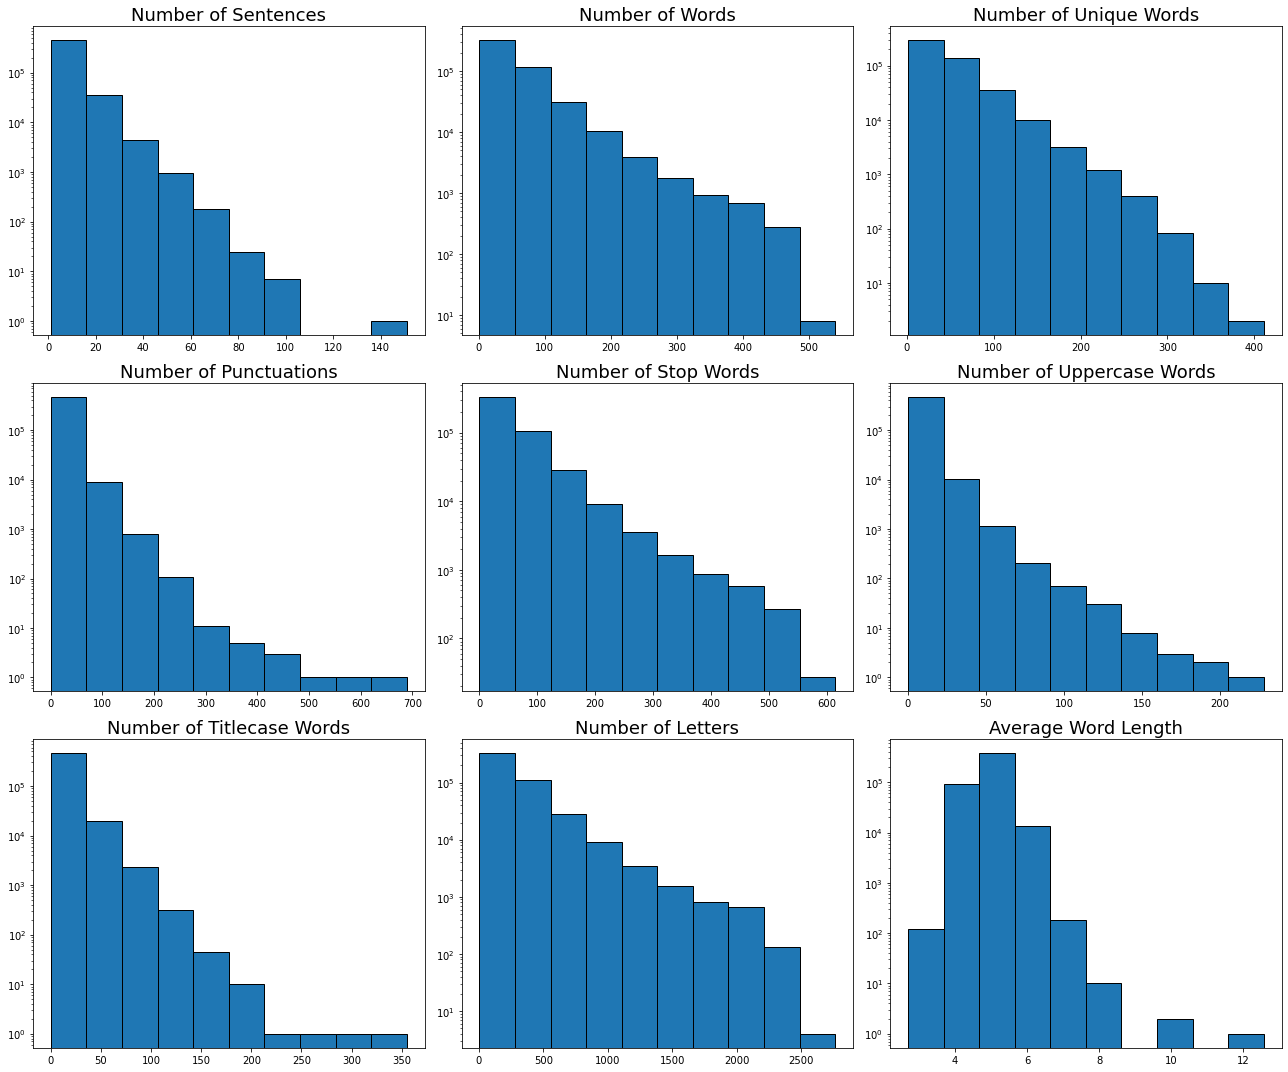

In [42]:
features = ['length_sent', 'length_word', 'set_word', 'length_punct',
            'length_stopwords', 'length_upper', 'length_title', 'length_char',
            'average_length_words']
titles = ['Number of Sentences', 'Number of Words', 'Number of Unique Words',
          'Number of Punctuations', 'Number of Stop Words',
          'Number of Uppercase Words', 'Number of Titlecase Words',
          'Number of Letters', 'Average Word Length']
d = dict(zip(features, titles))
# compare distributions of features by class in order to find the
# features that can identify fraudulent transactions
fig, axes = plt.subplots(3, 3) # generates figure and axis objects
fig.set_size_inches([18,15]) # adjust the figure size in inches
axes = axes.flatten()
for feature, ax in zip(d.keys(), axes):
    # plot the distribution of not helpful
    ax.hist(data[feature].values, edgecolor='k')
    ax.set_yscale('log')
    ax.set_title(d[feature], size=18)
plt.tight_layout()
plt.show()

In [43]:
for review in data[data.average_length_words > 7].review_clean.values:
    print(review)
    print()

salesperson cameron stansberri great total profession

nicol phenomen esthetician

great job profession punctual recommend servic technician respons friend

absolut recommend pharmaci pharmacist knowledg friend

probabl unprofession photograph town patienc studio filthi

courteous friend profession step compar competitor street

optometrist necessarili thorough shop staff friend small inventori

blackhawk hardwar garden fantast

main respons balloon helium extrem unaccept unprofession

darryl great met profession high recommend xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

serv purpos brilliant architectur

cooooooollllllll personnel friend line long

unprofession servic would recommend

faaaaaaaaaaaaaaaaaaaaaanci fanci fanci fancyp

zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz averag american make somewher dollar k k year like place window shop mani store cater top popul trust fund babi shallow credit card whore zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz uniqu artist touch 

* The reviews are pretty clean
* There are some problematic reviews; however they will not be counted into the text vector since we will apply threshold or cut-off

In [32]:
data[data.length_word < 3]

,review_id,review,review_stars,review_useful,review_clean,length_word,set_word,length_char,average_length_words,length_sent,length_punct,length_stopwords,length_upper,length_title
35464,qZd55U0mTOMOwvc5RCmlZg,Wow what a selection!,5.0,1,wow select,2,2,9,4.5,1,1,2,0,1
40231,27a46ILlo450hjNC-irvvw,Great place,5.0,0,great place,2,2,10,5.0,1,0,0,0,1
88215,QNqJgxhnTN6GD5iroyeTFg,Very helpful staff.,5.0,2,help staff,2,2,9,4.5,1,1,1,0,1
91097,xNDFBCUBp_x3k728Da3zeg,of course!,5.0,0,cours,1,1,5,5.0,1,1,1,0,0
91730,698Ip0pfefvvUEgcwvKUSA,did not have the best experience.,1.0,0,best experi,2,2,10,5.0,1,1,4,0,0
169110,DgmlfZym6x8FYT6Arv7pBw,Not a good place,1.0,2,good place,2,2,9,4.5,1,0,2,0,1
174247,PUiiNwDPV3YAEzMYYrUvwA,Big selection!,3.0,0,big select,2,2,9,4.5,1,1,0,0,1
185411,Kpj4x0-m3von9EHtLgcBKw,Cool,5.0,0,cool,1,1,4,4.0,1,0,0,0,1
223729,11uid_sgVDCmRB78BCNzrw,just another outlet,3.0,0,anoth outlet,2,2,11,5.5,1,0,1,0,0
224014,wxN3kHb4YV7sZQ1Suq9TbA,love the eagle!,4.0,0,love eagl,2,2,8,4.0,1,1,1,0,0


In [33]:
data.to_csv('yelp_review_processed.csv', index=False)

# Cumulative Distribution of Words

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
vectorized = cv.fit_transform(data.review_clean)

In [35]:
from collections import Counter
# generates a matrix of frequency for each word
# frequencies.size equals to number of unique words in the whole text
frequencies = np.sum(vectorized, axis=0)
# how many times each frequency occurs in the frequency array
# e.g. how many words appeared in the text exactly 1 time
# `[0]` selects the inside matrix where the frequencies are
# sum of the values of `counts_of_frequency` gives the number of unique words
counts_of_frequency = Counter(np.asarray(frequencies)[0])
# calculates percent for each frequency i.e.
# how many percent of data is belong to a frequency
# for example 1 frequency is 40% means that all words that appear
# in the text one time accounts for 40% of all words
percents = [counts_of_frequency[i] / frequencies.size for i in range(frequencies.size)]
# calculates the cummulative frequency
cumulative_frequency = np.cumsum(percents)

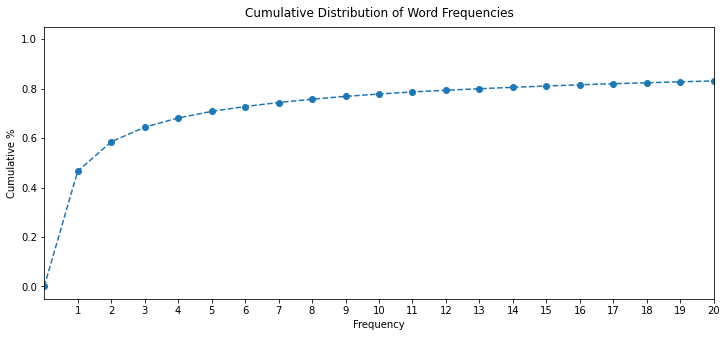

In [36]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(range(frequencies.size), cumulative_frequency, marker='o', linestyle='--')
ax.set_xlim(0, 20)
ax.set_xticks(range(1, 21))
ax.set_xticklabels(range(1, 21))
ax.set_xlabel('Frequency')
ax.set_ylabel('Cumulative %')
ax.set_title('Cumulative Distribution of Word Frequencies', pad=10)
plt.show()

In [37]:
words_freq = [(word, frequencies[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [44]:
# top 10 most frequent words
pd.DataFrame({'Word Top 20': [word for word, _ in words_freq[:10]],
              'Frequency Top 20' : ['{:,}'.format(freq) for _, freq in words_freq[:10]],
              'Word Bottom 20': [word for word, _ in words_freq[-10:]],
              'Frequency Bottom 20' : ['{:,}'.format(freq) for _, freq in words_freq[-10:]]},
              index=range(10))

,Word Top 20,Frequency Top 20,Word Bottom 20,Frequency Bottom 20
0,store,"255,567",suntour,1
1,get,"216,313",crosstrail,1
2,time,"216,215",topolino,1
3,would,"210,096",cdale,1
4,go,"199,735",prefrozen,1
5,great,"184,795",mgmts,1
6,one,"182,035",bowlin,1
7,place,"173,704",varier,1
8,servic,"172,579",balan,1
9,like,"169,958",okuyama,1


* In the above figure and table, we see that words that occur only one time in the corpus accounts for ~45% of the vocabulary.
* Moreover, the number of occurrence has a marginal effect of the cumulative distribution. In other words, the curve gets flatter as we move to the right of the graph.